<a href="https://colab.research.google.com/github/AIceDog/Pyotrch-Notes/blob/master/Notes%20about%20Liangqu%20Long%20Courses%20of%20Pytorch%20Deep%20Learning/CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

# Lenet5

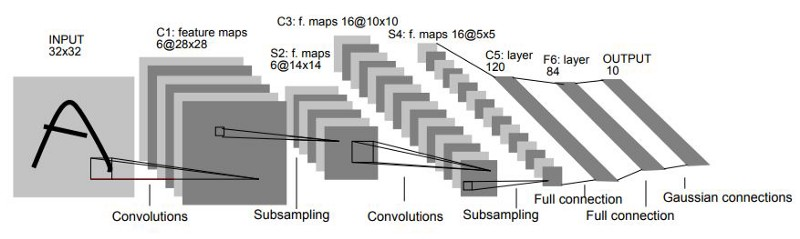

In [8]:
class Lenet5(nn.Module):   # all pytorch neural network class must inherit from nn.Module
  """
  for cifar10 dataset.
  """

  def __init__(self):
    super(Lenet5, self).__init__()

    self.conv_unit = nn.Sequential(
        # x : [batch_size, 3, 32, 32] => [batch_size, 6, 28, 28]
        nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1, padding = 0),   # convolution layer, from INPUT to C1  

        # x : [batch_size, 6, 28, 28] => [batch_size, 6, 14, 14]
        nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0),   # pooling layer, from C1 to S2

        # x : [batch_size, 6, 14, 14] => [batch_size, 16, 10, 10]
        nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),   # convolution layer, from S2 to C3  

        # x : [batch_size, 16, 10, 10] => [batch_size, 16, 5, 5]
        nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0),   # pooling layer, from C3 to S4
    )

    # fully connection layers
    # fc unit
    self.fc_unit = nn.Sequential(
        nn.Linear(16 * 5 * 5, 120),   # fully connected layer, from S4 to C5
        nn.ReLU(),
        nn.Linear(120, 84),   # fully connected layer, from C5 to F6
        nn.ReLU(),
        nn.Linear(84, 10)   # fully connected layer, from F6 to OUTPUT
    ) 

    # method to compute output image dimension
    tmp = torch.randn(2, 3, 32, 32)   # [batch_size, 3, 32, 32]
    out = self.conv_unit(tmp)   
    print(f'conv out : {out.shape}')   # will print '[batch_size, 16, 5, 5]'

    # use Cross Entropy Loss
    # self.criterion = nn.CrossEntropyLoss() # 一般对于分类问题使用 Cross Entropy, 对于 regression 问题使用 Mean Squared Error



  # all neural networks have forward funtion which represent of process of forward computation
  # backward will produce automatically based on forward process
  def forward(self, x):
    """
    :param x: [batch_size, 3, 32, 32]
    :return:
    """

    batchsz = x.size(0) # x.size(0) = x.shape[0]

    # convolution computation
    # [batch_size, 3, 32, 32] => [batch_size, 16, 5, 5]
    x = self.conv_unit(x)

    # flatten computation, make one processed image of conv_unit into one dimension 
    # [batch_size, 16, 5, 5] => [batch_size, 16 * 5 * 5]
    x = x.view(batchsz, -1) # we can also write 'x = x.view(batchsz, 16 * 5 * 5)'

    # fully connection computation
    # [batch_size, 16 * 5 * 5] => [batch_size, 10]
    logits = self.fc_unit(x)

    # [batch_size, 10]
    # pred = F.softmax(logits, dim = 1)
    # loss = self.criterion(logits, y)

    return logits

# nn.Linear(), nn.ReLU()... 是个类, 需要先初始化然后调用类里的函数
# F.softmax() 是函数, 可以直接调用

In [9]:
net = Lenet5()

tmp = torch.randn(2, 3, 32, 32)
out = net(tmp)
print(f'lenet out : {out.shape}')

conv out : torch.Size([2, 16, 5, 5])
lenet out : torch.Size([2, 10])


运行函数

In [11]:
def main():

  batch_size = 32

  # train
  cifar_train = datasets.CIFAR10('cifar', True, transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
  ]), download = True)   # cifar_train is data loader which loads one image one time 

  cifar_train = DataLoader(cifar_train, batch_size = batch_size, shuffle = True)   # cifar_train is data loader which loads batch_size images one time 

  # test
  cifar_test = datasets.CIFAR10('cifar', False, transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
  ]), download = True)   # cifar_train is data loader which loads one image one time 

  cifar_test = DataLoader(cifar_test, batch_size = batch_size, shuffle = True)   # cifar_train is data loader which loads batch_size images one time 


  x, label = iter(cifar_train).next()   # get one batch
  print(f'x : {x.shape}, label : {label.shape}')

  
  device = torch.device('cuda')
  model = Lenet5().to(device)
  criterion = nn.CrossEntropyLoss().to(device) # CrossEntropyLoss contains softmax
  optimizer = optim.Adam(model.parameters(), lr = 1e-3) # 优化器需要接受需要优化的参数, 需要优化的参数在网络里(model里)
  print(model)

  for epoch in range(1000):  
    
    model.train()   # 将模型变为 train 模式
    for batchidx, (x, label) in enumerate(cifar_train): # batchidx 代表第几个 batch
      # x : [batch_size, 3, 32, 32]
      # label : [batch_size], label is example output in Supervised Learning
      x, label = x.to(device), label.to(device) # let computation of x and label happen in cuda

      # logits : [batch_size, 10]
      # label : [batch_size]
      logits = model(x) # acctually it will execute forward funtion of model(Lenet5) to x
      loss = criterion(logits, label) # loss is tensor scalar(标量)

      # backprop
      optimizer.zero_grad() # 梯度清零, 因为每次 back propagation 的时候都会累加梯度
      loss.backward() # 进行梯度计算
      optimizer.step() # 将梯度更新到 optimizer 里的参数里面了, optimizer 里的参数就是 model.parameters()

    #
    print(f'epoch : {epoch}, loss.item() : {loss.item()}') # loss 是上面 for 循环里最后一个 batch 的 loss, 所以这个 loss 不能代表整个 train 过程


    model.eval()   # 将模型变为 test 模式
    with torch.no_grad():   # 这样运行 model(x) 的时候就不会再构建梯度图了, 构建梯度图主要是用来进行 back propagation
      # test
      total_correct = 0
      total_num = 0
      for x, label in cifar_test:
        # x : [batch_size, 3, 32, 32]
        # label : [batch_size]
        x, label = x.to(device), label.to(device) # let computation of x and label happen in cuda

        # logits : [batch_size, 10]
        logits = model(x)
        # pred : [batch_size]
        pred = logits.argmax(dim = 1)
        # pred : [batch_size] vs label : [batch_size] => scalar tensor
        total_correct += torch.eq(pred, label).float().sum().item()
        total_num += x.size(0)

      accuracy = total_correct / total_num
      print(f'epoch : {epoch}, accuracy : {accuracy}')

In [12]:
main()

Files already downloaded and verified
Files already downloaded and verified
x : torch.Size([32, 3, 32, 32]), label : torch.Size([32])
conv out : torch.Size([2, 16, 5, 5])
Lenet5(
  (conv_unit): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_unit): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
epoch : 0, loss.item() : 1.0481986999511719
epoch : 0, accuracy : 0.4492
epoch : 1, loss.item() : 1.0751709938049316
epoch : 1, accuracy : 0.4913
epoch : 2, loss.item() : 1.4776885509490967
epoch : 2, accuracy : 0.5167
epoch : 3, loss.item() : 0.8418770432472229
epoch : 3, accuracy : 0.5286
epoch : 4, loss.item() : 1.

KeyboardInterrupt: ignored